In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, json

%matplotlib inline

import pyusct
from pyusct.preprocess import load_usctsim_result, draw_input

from scipy import signal

from mpl_toolkits.mplot3d import Axes3D

## parameters

In [2]:
! ls /mnt/nas/2018-01-12_2

kgrid.mat	 step026  step059  step092  step125  step158  step191  step224
mask_points.mat  step027  step060  step093  step126  step159  step192  step225
medium.mat	 step028  step061  step094  step127  step160  step193  step226
param.json	 step029  step062  step095  step128  step161  step194  step227
param.mat	 step030  step063  step096  step129  step162  step195  step228
rfdata.mat	 step031  step064  step097  step130  step163  step196  step229
sensor.mat	 step032  step065  step098  step131  step164  step197  step230
sourse_wave.mat  step033  step066  step099  step132  step165  step198  step231
step001		 step034  step067  step100  step133  step166  step199  step232
step002		 step035  step068  step101  step134  step167  step200  step233
step003		 step036  step069  step102  step135  step168  step201  step234
step004		 step037  step070  step103  step136  step169  step202  step235
step005		 step038  step071  step104  step137  step170  step203  step236
step006		 step039  step072  step105  ste

In [3]:
result_path = "/mnt/nas/2018-01-12_2/"

## シミュレーション結果読み込み

In [ ]:
param, arr_cart_pos, mask_points, map_speed, map_dens, rfdata = load_usctsim_result(result_path)

#param

シミュレーション入力の音速画像、密度画像、リング相対位置を描画

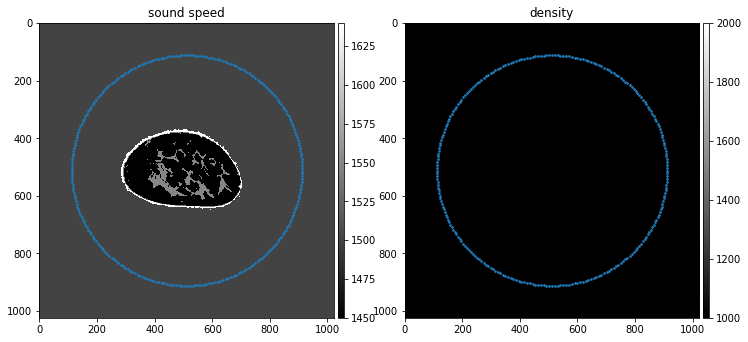

In [6]:
draw_input(mask_points, map_speed, map_dens)

RFデータのサイズを確認

In [7]:
rfdata.data.shape

(256, 256, 4374)

(送信素子数, 受信素子数, 時系列サンプリング数)となっている

## 標的位置に対するRFデータサブセットの抽出

In [29]:
# 標的位置（実空間座標）
target = [0.02, 0.02]

# 入力RFデータ抽出範囲
offset_min = -500
offset_max = 500
offset_int = 1

In [30]:
map_time_pos, subset = rfdata.getPointSubset(target, offset_min, offset_max, offset_int)

RFデータサブセットのサイズを確認

In [10]:
subset.shape

(256, 256, 1000)

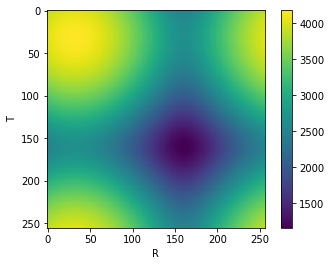

In [11]:
plt.imshow(map_time_pos, interpolation='nearest')
plt.xlabel('R')
plt.ylabel('T')
plt.colorbar()

### サンプル可視化

In [12]:
sample_T = 100
sample_R = 100
sample_t = - offset_min/offset_int

サンプル時刻におけるTR断面

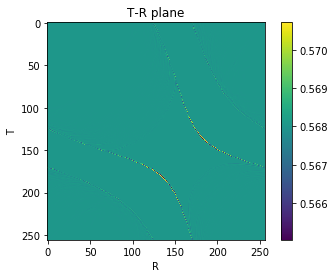

In [13]:
plt.imshow(subset[:,:,sample_t])
plt.xlabel('R')
plt.ylabel('T')
plt.title('T-R plane')
plt.colorbar()

サブセット抽出前の、ある送受信ペアにおける時系列波形を確認

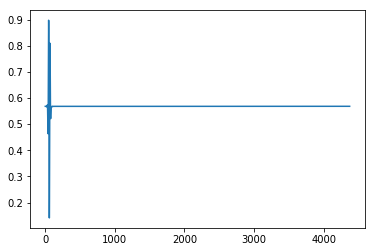

In [14]:
plt.plot(rfdata.data[sample_T,sample_R,:])
#plt.ylim(-0.001, 0.001)

同じ送受信ペアの、サブセット内での時系列確認

arrival time: 2935


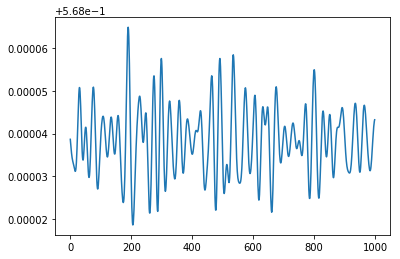

In [15]:
print('arrival time: '+str(map_time_pos[sample_T,sample_R]))
plt.plot(subset[sample_T,sample_R,:])
#plt.ylim(-0.001, 0.001)

### 場所を変えたときに結果も変わることを確認

In [47]:
# 標的位置（実空間座標）
target = [0.01, 0.01]

map_time_pos, subset = rfdata.getPointSubset(target, offset_min, offset_max, offset_int)

# RFデータサブセットのサイズを確認

(256, 256, 1000)


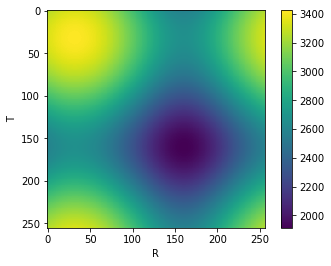

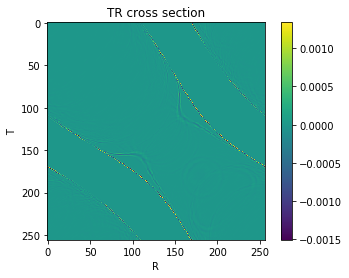

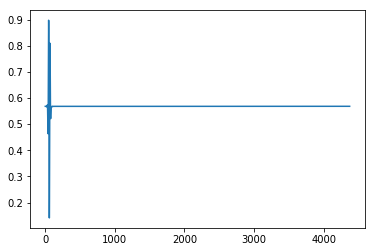

arrival time: 2702


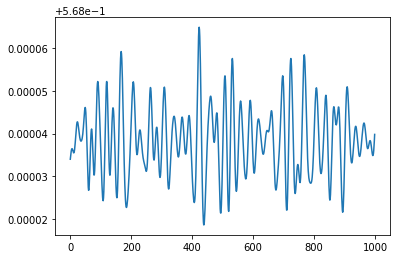

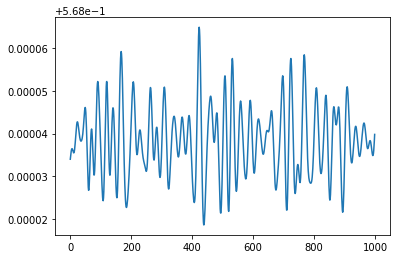

In [64]:
print(subset.shape)

plt.imshow(map_time_pos, interpolation='nearest')
plt.xlabel('R')
plt.ylabel('T')
plt.colorbar()
plt.show()

# サンプル時刻におけるTR断面

plt.imshow(subset[:,:,sample_t] - np.mean(subset[:,:,sample_t]))
plt.xlabel('R')
plt.ylabel('T')
plt.title('TR cross section')
plt.colorbar()
plt.show()

# サブセット抽出前の、ある送受信ペアにおける時系列波形を確認
plt.plot(rfdata.data[sample_T,sample_R,:])
plt.show()

# 同じ送受信ペアの、サブセット内での時系列確認
t_ = map_time_pos[sample_T,sample_R]
print('arrival time: '+str(t_))
plt.plot(rfdata.data[sample_T,sample_R,t_+offset_min:t_+offset_max])
plt.show()
plt.plot(subset[sample_T,sample_R,:])
plt.show()

## SAで行っている処理の確認

In [65]:
subset.shape

(256, 256, 1000)

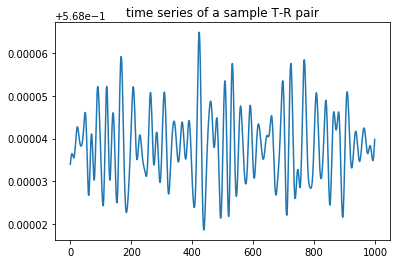

In [66]:
# cnt = 1
# for T in range(0, subset.shape[0], 16):
#     for R in range(0, subset.shape[1], 16):
plt.plot(subset[sample_T, sample_R, :])
# plt.ylim(ymin=np.min(subset), ymax = np.max(subset))
# cnt += 1
plt.title('time series of a sample T-R pair')
plt.show()

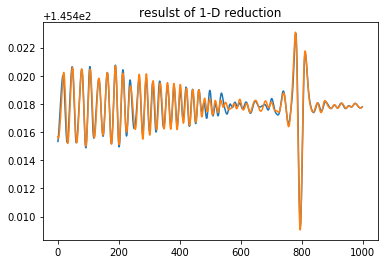

In [67]:
plt.plot( np.sum( subset, axis=0)[sample_R] )
plt.plot( np.sum( subset, axis=1)[sample_T] )
plt.title('resulst of 1-D reduction')
plt.show()

In [68]:
subset.shape

(256, 256, 1000)

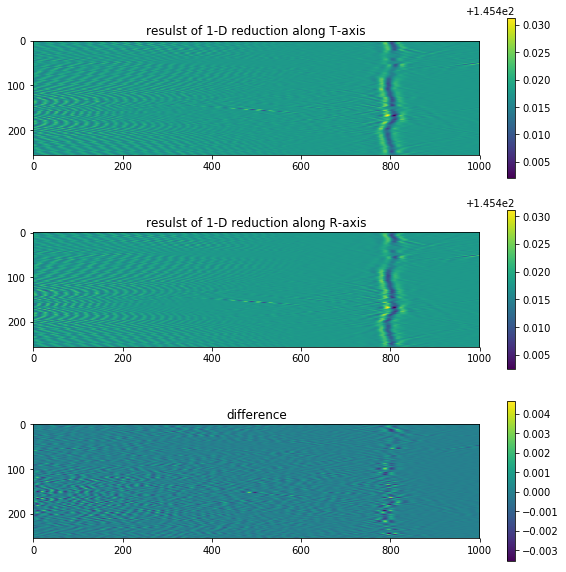

In [79]:
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.imshow( np.sum( subset, axis=0) )
plt.title('resulst of 1-D reduction along T-axis')
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow( np.sum( subset, axis=1) )
plt.title('resulst of 1-D reduction along R-axis')
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow( np.sum( subset, axis=0)  - np.sum( subset, axis=1))
plt.title('difference')
plt.colorbar()

plt.show()

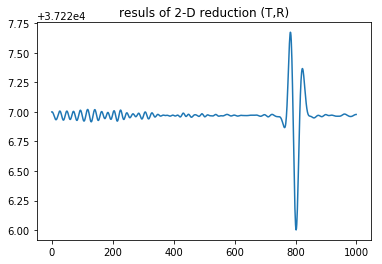

In [80]:
subset_reduced = np.sum(np.sum(subset, axis=0), axis=0)
plt.plot(subset_reduced)
plt.title('resuls of 2-D reduction (T,R)')
plt.show()

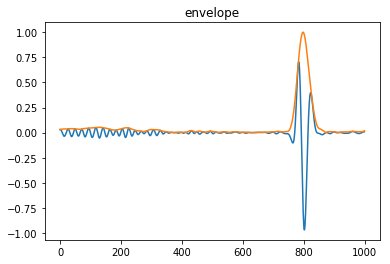

0.999677415316


In [81]:
subset_reduced_env = abs(signal.hilbert(subset_reduced - np.mean(subset_reduced)))
plt.plot(subset_reduced - np.mean(subset_reduced))
plt.plot(subset_reduced_env)
plt.title('envelope')
plt.show()

print np.max(subset_reduced_env)

## RFサブセットからSAを再現

In [ ]:
c = 8 # compression rate

out_image = np.zeros((param["grid"]["Ny"]/c, param["grid"]["Nx"]/c))

for iy in range(0, param["grid"]["Ny"], c):
    print iy,
    for ix in range(0, param["grid"]["Nx"], c):
        y = (iy - param["grid"]["Ny"]/2) * param["grid"]["dy"]
        x = (ix - param["grid"]["Nx"]/2) * param["grid"]["dx"]
        if np.linalg.norm(np.array([y,x])) > param["ringarray"]["radius"]:
            continue
        
        _, submat = rfdata.getPointSubset([y, x], offset_min, offset_max, offset_int)
        
        submat_reduced = np.sum(np.sum(submat, axis=0), axis=0)
        submat_reduced_env = abs(signal.hilbert(submat_reduced - np.mean(submat_reduced)))

        out_image[iy/c, ix/c] = np.max(submat_reduced_env)

 8

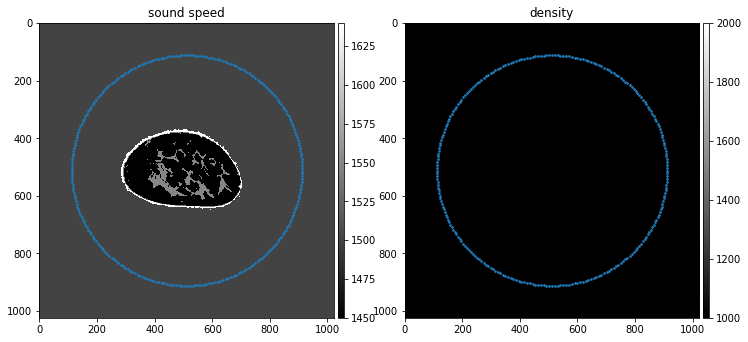

In [98]:
draw_input(mask_points, map_speed, map_dens)

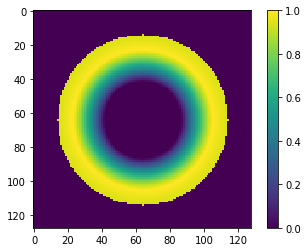

In [128]:
plt.imshow(out_image)
plt.colorbar()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


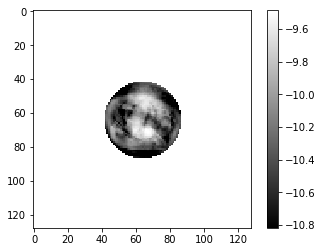

In [130]:
plt.imshow(np.log(out_image.T), interpolation='nearest', cmap='gray', 
           vmax = np.log(np.max(out_image[56:72, 56:72]) ),
            vmin = np.log(np.min(out_image[56:72, 56:72])*1.1 )
          )
plt.colorbar()